In [1]:
import torch
from torch.autograd import Variable
from torch.distributions import Normal
from functorch import vmap
import matplotlib.pylab as plt
import numpy as np
import scipy.stats as ss
import pickle
import random

In [2]:
import sys
sys.path.insert(0,'vp_class/')

In [3]:
from class_tou_v4_updated import tOU, tou_gradient

This code applies variational inference based on time-dependent OU processes to the observations drawn from the double well system SDE, as defined below. Note that we have chosen observational noise, i.e. variance of Gaussian noise and SDE variance to be 0.64 and 0.01 repectively.

m(t) = $\alpha$t + $m_{0}$

1. Simulate prior process, i.e. double-well system whose SDE is given by

$dX_{t} = 4X_{t}(1-X^{2}_{t})dt + \sigma dW_{t}$

In [8]:
with open('EX04_DW', 'rb') as f:
    prior = pickle.load(f)
    likelihood = pickle.load(f)
    std = pickle.load(f)

In [9]:
def prior_drift (s, x_s):
    return 4 * x_s * (1 - (x_s ** 2))

In [10]:
true_sde_pts, true_sde_trj = prior[0], prior[1]
obs, obs_time = likelihood[0], likelihood[1]
sde_sigma, obs_sigma = std[0], std[1]

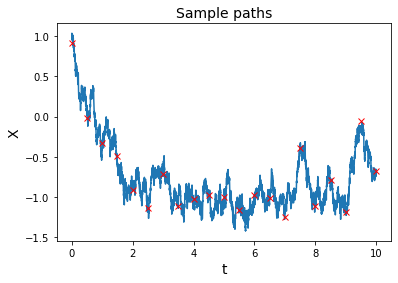

In [11]:
# Plot paths
plt.plot(true_sde_pts,true_sde_trj)
plt.plot(obs_time, obs, "rx")
plt.xlabel("t", fontsize=14)
plt.ylabel("X", fontsize=14)
plt.title("Sample paths", fontsize=14)
plt.show()


In [12]:
true_sde_pts = torch.from_numpy(true_sde_pts)
true_sde_trj = torch.from_numpy(true_sde_trj)

obs = torch.from_numpy(obs)
obs_time = torch.from_numpy(obs_time)

Variational inference: KL

2. Implement Variational inference based on $\textbf{time-inhomogeneous}$ OU process with SDE:

$$dX_{t} = [-\frac{a}{at+b}X_{t} + (ct+d)] dt + \sigma^{2} dW_{t}$$

$$\mathbb{E}_{P^{Z}}[\log\exp{\frac{dP^{X}}{dP^{Z}}(Z)] = \frac{1}{2}\mathbb{E}_{P^{Z}}[\int_{t_{0}}}^{t_{1}}|\frac{4Z_{t}(1-Z^{2}_{t}) + \frac{a}{at+b}Z_{t} - (ct+d)}{\sigma}|^{2}dt]$$


In [13]:
class ELBO:
    """
        ELBO with
            variational process (q): time-inhomogeneous OU process
            prior process (p): double-well system
            
        This class computes: - KL(q|p) + NLL(y|z)  where z \sim q
    """
    def __init__(self, ou):
        self.ou = ou
        
        self.alpha = ou.alpha
        self.beta = ou.beta
        self.r = ou.r
        
        self.sigma = ou.sigma
        

    def KL(self, prior_drift):
        """
            This function requires the function corresponding to prior drift function
        """
        # Save parameter specification from ou class
        alpha, beta, r, sigma = self.alpha, self.beta, self.r, self.sigma
        m0 = self.ou.trj[:, 0].reshape(-1, 1)
        
        def B(s, beta):
            return (s+1) ** beta
        
        def m(s):
            return alpha * (B(s, beta) - 1) + m0
            
        def m_(s):
            return alpha * beta * B(s, beta-1)
        
        t = self.ou.pts - self.ou.pts[:, 0].reshape(-1, 1)
        
        # Evaluate the drift function of the approximating processes
        g_of_x = -r * (self.ou.trj - m(t)) + m_(t)
        
        # Evaluate the drift function of the model (prior process)
        f_of_x = prior_drift(t, self.ou.trj)
        
        # Compute the term inside the KL divergence
        
        F_of_X = abs(((f_of_x - g_of_x) / sigma) ** 2)
        
        dt = t[:, -1] - t[:, 0]
        
        return 0.5 * torch.sum(F_of_X, axis=1).reshape(-1, 1) / F_of_X.shape[1] * dt.reshape(-1, 1)
            
    def log_prob(self, obs, obs_sigma):
        """
            Compute the log-likelihood
            likelihood function is normal density N(obs, var)
            obs.shape = D * 1 (D: # of sample)
        """
        def log_pdf(obs, z, obs_sigma):
            return ss.norm.logpdf(obs, loc=z, scale=obs_sigma)
            
        return torch.from_numpy(log_pdf(obs, self.ou.trj[:, -1].reshape(-1, 1), obs_sigma))


**Variational inference: a piece-wise approximation**

In [14]:
import tqdm as tq

In [15]:
def score_estimate(s0, sK, current_pars, sigma, obs, obs_sigma, init_dist, M, K):
    """
        Returns stochastic estimates of the gradient of the ELBO with respect to parameters including
            alpha, r, beta
        
        M: # of Monte Carlo samples
        
    """
    assert obs.shape[0] == 1, "observation must be 1-d torch.array"
    
    
    # Reshape every parameter into (M,1) torch.array
    SIGMA = sigma.repeat(M, 1)
    OBS = obs.repeat(M, 1)
    # Simulate sample path
    # Note that z0 = m0
    
    pars = {key:val.repeat(M, 1) for key,val in current_pars.items()}
    
    vi = tOU(t0=s0, t1=sK, parameters = pars, sde_sigma=SIGMA, init_dist = init_dist, timegrid = 'False', dN=K)

    # Compute the ELBO 
    elbo = ELBO(vi)
    score_func = tou_gradient(vi.pts, vi.trj, pars, SIGMA, init_dist)
    f_of_x = -elbo.log_prob(OBS, obs_sigma) + elbo.KL(prior_drift)
    
    # Variational objective
    vi_obj = {'NELBO': torch.nanmean(f_of_x).item(), 'KL': torch.nanmean(elbo.KL(prior_drift)).item(), 'NLL': -1 * torch.nanmean(elbo.log_prob(OBS, obs_sigma)).item() }
    
    return {key: torch.nanmean(f_of_x * score_func[key]) for key in pars.keys()}, vi_obj

In [16]:
def AdamStep(g_t, m_t, v_t, beta_1, beta_2, t):
    """
        compute bias corrected moments
    """
#     print(g_t, m_t, v_t, beta_1, beta_2, t)
    m_t_next = beta_1 * m_t + (1 - beta_1) * g_t
    v_t_next = beta_2 * v_t + (1 - beta_2) * g_t ** 2
    
    m_t_corrected = m_t_next / (1 - (beta_1 ** t))
    v_t_corrected = v_t_next / (1 - (beta_2 ** t))
    
#     print(m_t_corrected, v_t_corrected)
    return m_t_corrected, v_t_corrected

def AdamGrad(current_pars, current_grad, prev_moments,  beta_1, beta_2, learning_rate = 0.01, smooth_term = 1e-8):
    assert type(current_pars) == type(current_grad) == type(prev_moments) == dict, "Current_grad must be a dict"
    """
        Perform one-step Adam gradient descent
    """
    new_pars = {}
    for key in current_pars.keys():
        if key == 'r':
            m_t, v_t = AdamStep(current_grad[key], prev_moments[key][0], prev_moments[key][1], beta_1, beta_2, prev_moments['t'])
            new_pars[key] = current_pars[key] - learning_rate / np.sqrt(v_t + smooth_term) * m_t
            value = new_pars[key]
            lr = learning_rate
            while value <= 0:
                value = current_pars[key] - lr / np.sqrt(v_t + smooth_term) * m_t
                lr *= 0.5
            new_pars[key] = value
            
        else:
            m_t, v_t = AdamStep(current_grad[key], prev_moments[key][0], prev_moments[key][1], beta_1, beta_2, prev_moments['t'])
            new_pars[key] = current_pars[key] - learning_rate / np.sqrt(v_t + smooth_term) * m_t
        
        # Save moments for next iteration    
        prev_moments[key][0] = m_t
        prev_moments[key][1] = v_t
    
    prev_moments['t'] += 1
    
    return new_pars
    
    
    

In [17]:
def E_of_X ( init_pts, pts, parameters ):
    """
        Return mean of the process (which has analytical expression)
    """

    alpha = parameters['alpha']
    beta = parameters['beta']
    r = parameters['r']
    
    return alpha * ((pts + 1) ** beta - 1) + init_pts
    

In [18]:
def V_of_X (pts, parameters, prev_parameters, sde_sigma):
    """
        Return standard deviation of the process (from its analytical expression)
    """
    r = parameters['r']
    
    if prev_parameters == False:
        # for the first time step, we compute the variance given the initial point is fixed
        return torch.sqrt(0.5 * sde_sigma * sde_sigma / r * (1 - torch.exp(-2 * r * pts)))
    
    else:
        # for subsequent time steps, we compute the variance given the initial state is a random variable from approximate posterior
        prev_r = prev_parameters['r']

        v_0 = 0.5 * sde_sigma * sde_sigma / prev_r

        return torch.sqrt(0.5 * sde_sigma * sde_sigma / r * (1 - torch.exp(-2 * r * pts) * (2*r/(sde_sigma * sde_sigma) * v_0 - 1 )))


In [19]:
def get_PostMoment(t0, tT, parameters, prev_parameters, sde_sigma, init_pts, vN):
    """
        Returns approximate posterior's mean and standard deviation
    """
    # Get time-grid between s0 and sK
    
    t = torch.linspace(0, (tT-t0).item(), vN+2)[1:].reshape(-1, 1)
    mean = E_of_X(init_pts, t, parameters)
    std = V_of_X(t, parameters, prev_parameters, sde_sigma)

    return t.flatten(), mean.flatten(), std.flatten()

**To be added: 1. parameter update history, 2. elbo, KL, and loglikelihood estimate, 3. randomizing initial state**

In [20]:
def Optimize(sde_sigma, obs, obs_time, obs_sigma, M, IT, vN, learning_rate, K,  init_state = "Random", Optimizer="Adam", beta_1 = 0.9, beta_2 = 0.999, smooth_term = 1e-8, FIX_PAR=False):
    """
        vN: # of time points between in each obs interval on which mean of the approximate posterior process will be evaluated
    """
    assert type(sde_sigma) == torch.Tensor, "SDE sigma must be a torch.Tensor"
    assert type(obs) == torch.Tensor, "obs must be a torch.Tensor"

    N_of_Pars = 3
    
    T = obs.shape[0]
    
    v_N = T * (vN+1) - vN
    
    VP_PTS = np.zeros(v_N)
    VP_MEAN = np.zeros(v_N)
    VP_STD = np.zeros(v_N)
    
    # Intialize the state at the first observation
    init_mean = obs[0]
    VP_MEAN[0] = init_mean
    
    past_grad = {'alpha':np.zeros((T-1, IT)), 'beta':np.zeros((T-1, IT)), 'r':np.zeros((T-1, IT))}
    past_pars = {'alpha':np.zeros((T-1, IT)), 'beta':np.zeros((T-1, IT)), 'r': np.zeros((T-1, IT))}
    past_vi = {'NELBO':np.zeros((T-1, IT)), 'KL':np.zeros((T-1, IT)), 'NLL':np.zeros((T-1, IT))}
    
    for t in tq.tqdm(range(1, T)):
        s0 = obs_time[t-1]
        sK = obs_time[t]
        
        if init_state == 'Random':
            if t == 1:
                init_dist = init_mean
            else:
                init_dist = Normal(loc=init_mean, scale= init_std)
        else:
            init_dist = init_mean
            
        # Initialize a set of parameters
        current_pars = {key:torch.randn(1) for key in past_grad.keys() if key != 'r'}
        current_pars['r'] = torch.tensor(3.)

        if Optimizer == "Adam":
            prev_moments = {key:[0, 0] for key in current_pars.keys()}
            prev_moments['t'] = 1
            
#    past_grad = {key:torch.tensor([0.01]) for key in current_pars.keys()}
    
        for i in range(IT):
            if (i % (IT/2) == 0):
                for key in current_pars.keys():
                    print(str(i) +"/ " + key + ": "+ str(current_pars[key].item()) )
                    
            # Take gradient descent algorithm based on AdaGrad
            
            # Obtain stochastic estimate of the gradients based on score function estimator
            current_grad, vi_objective = score_estimate(s0, sK, current_pars, sde_sigma, obs[t], obs_sigma, init_dist, M, K)
            
            for key in vi_objective.keys():
                past_vi[key][t-1, i] = vi_objective[key]
            if (i % (IT/2) == 0) | (i == IT-1):
                print(str(i) +"/ " + "Negative ELBO: "+ str(vi_objective['NELBO']))
            
#             if vi_objective['ELBO'] < 20:
#                 break
            # Take one gradient step based on the AdaGrad
            if Optimizer == "Adam":
                current_pars = AdamGrad(current_pars, current_grad, prev_moments, beta_1, beta_2, learning_rate, smooth_term)
                
            else:
                current_pars = Grad_Descent(current_pars, current_grad, learning_rate)
            
            if FIX_PAR != False:
                for key in FIX_PAR.keys():
                    current_pars[key] = FIX_PAR[key]
            
            for key in current_grad.keys():
                past_grad[key][t-1, i] = current_grad[key].item()
                past_pars[key][t-1, i] = current_pars[key].item()
            
        if t == 1:
            prev_pars = False
            
        # Obtain moments of approximating processes (note that their forms are tractable)
        vp_pts, vp_mean, vp_std = get_PostMoment(s0, sK, current_pars, prev_pars, sde_sigma, init_mean, vN)
        VP_PTS[(vN+1)*(t-1)+1:(vN+1)*t+1] = obs_time[t-1] + vp_pts
        VP_MEAN[(vN+1)*(t-1)+1:(vN+1)*t+1] = vp_mean
        VP_STD[(vN+1)*(t-1)+1:(vN+1)*t+1] = vp_std
        
        init_mean = vp_mean[-1]
        init_std = vp_std[-1]
        
        if t > 1:
            prev_pars = current_pars
        
        print("observation: " + str(obs[t].item()) + " variational mean: " + str(init_mean.item()))
    return VP_PTS, VP_MEAN, VP_STD, past_pars, past_grad, past_vi

Examine the convergence of parameters / model fit across different initializations/number_of_iterations

In [21]:
output = []
for it in tq.tqdm([50]):
    vp__pts, vp__mean, vp__std, vp__pars, vp__grads, vp__obj = Optimize(torch.tensor([sde_sigma]),\
                                                      obs, obs_time, obs_sigma, \
                                                      init_state="Random", M=1500, \
#                                                       FIX_PAR = FIX_PAR,
                                                               \
                                                      IT=it, vN=200, K=1000, learning_rate=0.1, \
                                                      Optimizer="Adam", beta_1 = 0.3, beta_2 = 0.01)
    output.append([vp__pts, vp__mean, vp__std, vp__pars, vp__grads])

  0%|                                                    | 0/20 [00:00<?, ?it/s]

0/ alpha: -0.28015613555908203
0/ beta: -0.44361594319343567
0/ r: 3.0
0/ Negative ELBO: 331.3837743940878
25/ alpha: 1.843449592590332
25/ beta: -1.5635197162628174
25/ r: 5.6143066624832425
25/ Negative ELBO: 19.036049689241604



  5%|██▏                                         | 1/20 [00:20<06:30, 20.55s/it]

49/ Negative ELBO: 18.018436051257023
observation: -0.01439203191118106 variational mean: -0.038864795438079525
0/ alpha: 0.03824939578771591
0/ beta: -0.5264385938644409
0/ r: 3.0
0/ Negative ELBO: 68.52231968497283
25/ alpha: 1.020219326019287
25/ beta: -1.3671430349349976
25/ r: 5.5793235893374975
25/ Negative ELBO: 34.77610142865135



 10%|████▍                                       | 2/20 [00:41<06:11, 20.66s/it]

49/ Negative ELBO: 25.672737885774385
observation: -0.32827043739631845 variational mean: -0.2884541451931
0/ alpha: -0.9231759905815125
0/ beta: -0.4686053991317749
0/ r: 3.0
0/ Negative ELBO: 84.51550423208727
25/ alpha: -0.6608241200447083
25/ beta: 1.0572118759155273
25/ r: 5.576099233543611
25/ Negative ELBO: 35.64476425706234



 15%|██████▌                                     | 3/20 [01:02<05:53, 20.79s/it]

49/ Negative ELBO: 23.290373564163602
observation: -0.4948989413864352 variational mean: -0.4510444402694702
0/ alpha: 0.9681834578514099
0/ beta: -1.4713977575302124
0/ r: 3.0
0/ Negative ELBO: 45.12129642855661
25/ alpha: 1.0589245557785034
25/ beta: -1.519607663154602
25/ r: 5.578645465554066
25/ Negative ELBO: 28.74916303717411



 20%|████████▊                                   | 4/20 [01:23<05:33, 20.84s/it]

49/ Negative ELBO: 23.80207415370151
observation: -0.9124221160427716 variational mean: -0.8791388273239136
0/ alpha: 0.40774989128112793
0/ beta: 0.5880928635597229
0/ r: 3.0
0/ Negative ELBO: 84.390900075079
25/ alpha: -0.9400529861450195
25/ beta: 0.39520278573036194
25/ r: 5.588941993505983
25/ Negative ELBO: 33.59838020165694



 25%|███████████                                 | 5/20 [01:44<05:13, 20.88s/it]

49/ Negative ELBO: 25.71130589090627
observation: -1.1408071917190732 variational mean: -1.1227070093154907
0/ alpha: -1.0479384660720825
0/ beta: -0.49206241965293884
0/ r: 3.0
0/ Negative ELBO: 62.06331365318381
25/ alpha: -1.2821860313415527
25/ beta: -0.8478010296821594
25/ r: 5.583843970820791
25/ Negative ELBO: 29.414978864232936



 30%|█████████████▏                              | 6/20 [02:05<04:52, 20.91s/it]

49/ Negative ELBO: 26.245728797040634
observation: -0.7102513865260666 variational mean: -0.7376925945281982
0/ alpha: -1.5199874639511108
0/ beta: -0.8159419894218445
0/ r: 3.0
0/ Negative ELBO: 247.26883756077856
25/ alpha: -1.144799828529358
25/ beta: 0.8838362693786621
25/ r: 5.555503159227016
25/ Negative ELBO: 35.65055494878632



 35%|███████████████▍                            | 7/20 [02:26<04:32, 20.95s/it]

49/ Negative ELBO: 24.228601035260002
observation: -1.1178012599865634 variational mean: -1.1743090152740479
0/ alpha: 1.0966302156448364
0/ beta: -0.46595075726509094
0/ r: 3.0
0/ Negative ELBO: 99.98840538582924
25/ alpha: 0.5100998282432556
25/ beta: 0.7388818264007568
25/ r: 5.615688678256904
25/ Negative ELBO: 31.37961205450165



 40%|█████████████████▌                          | 8/20 [02:47<04:11, 20.95s/it]

49/ Negative ELBO: 26.853458862671783
observation: -1.0252658832880799 variational mean: -1.0708208084106445
0/ alpha: -0.14196939766407013
0/ beta: 1.2361327409744263
0/ r: 3.0
0/ Negative ELBO: 67.08785828875587
25/ alpha: 0.3545111119747162
25/ beta: 0.47861284017562866
25/ r: 5.606037554958721
25/ Negative ELBO: 31.428606850255406



 45%|███████████████████▊                        | 9/20 [03:08<03:50, 20.96s/it]

49/ Negative ELBO: 25.36669692942937
observation: -0.9739169439418749 variational mean: -0.9412240386009216
0/ alpha: -0.457029789686203
0/ beta: 0.7242178916931152
0/ r: 3.0
0/ Negative ELBO: 53.63422217482651
25/ alpha: 0.35711610317230225
25/ beta: -0.3398812711238861
25/ r: 5.594849516044257
25/ Negative ELBO: 30.709296295622096



 50%|█████████████████████▌                     | 10/20 [03:29<03:29, 20.98s/it]

49/ Negative ELBO: 25.158297441919245
observation: -0.99926274093855 variational mean: -0.9977455735206604
0/ alpha: 0.8094393610954285
0/ beta: -2.431760787963867
0/ r: 3.0
0/ Negative ELBO: 116.24929705746375
25/ alpha: 0.5269728899002075
25/ beta: -0.9582841396331787
25/ r: 5.615164798226619
25/ Negative ELBO: 33.811442367802336



 55%|███████████████████████▋                   | 11/20 [03:50<03:08, 20.98s/it]

49/ Negative ELBO: 27.91666715350639
observation: -1.1567929484848898 variational mean: -1.1083496809005737
0/ alpha: 0.3601051867008209
0/ beta: 0.6393435001373291
0/ r: 3.0
0/ Negative ELBO: 48.11994785857426
25/ alpha: 0.43879178166389465
25/ beta: 0.606937050819397
25/ r: 5.600250477532817
25/ Negative ELBO: 32.24014286835509



 60%|█████████████████████████▊                 | 12/20 [04:10<02:47, 20.97s/it]

49/ Negative ELBO: 25.394200706493866
observation: -0.9752134163736371 variational mean: -0.9955151081085205
0/ alpha: 0.9221227765083313
0/ beta: 0.29111623764038086
0/ r: 3.0
0/ Negative ELBO: 49.73708405961589
25/ alpha: 0.11930778622627258
25/ beta: 0.11397990584373474
25/ r: 5.5764563399762475
25/ Negative ELBO: 29.282496246286563



 65%|███████████████████████████▉               | 13/20 [04:31<02:26, 20.96s/it]

49/ Negative ELBO: 23.98706219722269
observation: -1.014213607555824 variational mean: -1.0016405582427979
0/ alpha: -1.5460405349731445
0/ beta: 1.5780112743377686
0/ r: 3.0
0/ Negative ELBO: 748.8566584353438
25/ alpha: -0.7123336791992188
25/ beta: 0.7342295050621033
25/ r: 5.626358071850716
25/ Negative ELBO: 36.15438863528155



 70%|██████████████████████████████             | 14/20 [04:52<02:05, 20.97s/it]

49/ Negative ELBO: 29.353915128733256
observation: -1.2424416992878282 variational mean: -1.077568531036377
0/ alpha: -0.255596786737442
0/ beta: -0.4010232985019684
0/ r: 3.0
0/ Negative ELBO: 182.86702613831832
25/ alpha: -1.5298774242401123
25/ beta: -1.705945372581482
25/ r: 5.628532330528351
25/ Negative ELBO: 31.19350759753835



 75%|████████████████████████████████▎          | 15/20 [05:13<01:44, 20.98s/it]

49/ Negative ELBO: 24.3622773455575
observation: -0.3926882918617478 variational mean: -0.23552680015563965
0/ alpha: -1.0137585401535034
0/ beta: -0.006954420357942581
0/ r: 3.0
0/ Negative ELBO: 288.6717593493242
25/ alpha: -1.5646942853927612
25/ beta: 0.8790072798728943
25/ r: 5.589806203311031
25/ Negative ELBO: 44.27676401962045



 80%|██████████████████████████████████▍        | 16/20 [05:34<01:23, 20.99s/it]

49/ Negative ELBO: 24.793890121054897
observation: -1.1167338908509747 variational mean: -1.1554733514785767
0/ alpha: -0.4515942931175232
0/ beta: 0.1342957466840744
0/ r: 3.0
0/ Negative ELBO: 106.7656555099152
25/ alpha: -1.036094069480896
25/ beta: -1.1911811828613281
25/ r: 5.678154352484331
25/ Negative ELBO: 30.28772574494263



 85%|████████████████████████████████████▌      | 17/20 [05:55<01:02, 20.99s/it]

49/ Negative ELBO: 26.259234210369023
observation: -0.7854129658719544 variational mean: -0.753038227558136
0/ alpha: 0.32653626799583435
0/ beta: -0.35476940870285034
0/ r: 3.0
0/ Negative ELBO: 88.67327030713078
25/ alpha: 1.1369078159332275
25/ beta: -1.088940143585205
25/ r: 5.591353697329941
25/ Negative ELBO: 30.616335964236598



 90%|██████████████████████████████████████▋    | 18/20 [06:16<00:41, 20.97s/it]

49/ Negative ELBO: 24.163416071582784
observation: -1.1921947313074546 variational mean: -1.1693655252456665
0/ alpha: -0.8444191217422485
0/ beta: 3.7063889503479004
0/ r: 3.0
0/ Negative ELBO: 10033.459544833195
25/ alpha: 0.6543061137199402
25/ beta: 2.5333168506622314
25/ r: 6.428549994555899
25/ Negative ELBO: 30.894558827978738



 95%|████████████████████████████████████████▊  | 19/20 [06:37<00:20, 20.94s/it]

49/ Negative ELBO: 31.158755020312984
observation: -0.056368394200432506 variational mean: -0.3189825415611267
0/ alpha: 1.9745876789093018
0/ beta: -1.5852574110031128
0/ r: 3.0
0/ Negative ELBO: 156.84219452741473
25/ alpha: 1.0994287729263306
25/ beta: -0.8161231279373169
25/ r: 5.652581924993793
25/ Negative ELBO: 27.72631053824352



100%|████████████████████████████████████████████| 1/1 [06:59<00:00, 419.07s/it]

49/ Negative ELBO: 23.0726771780995
observation: -0.6748959569313668 variational mean: -0.6378776431083679


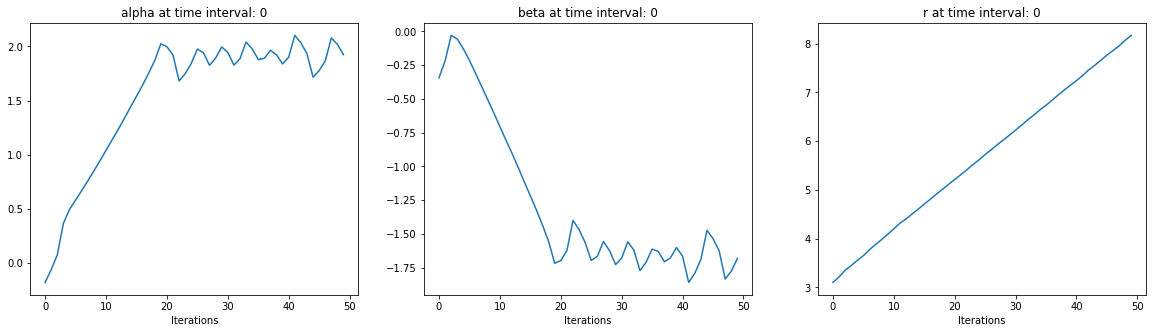

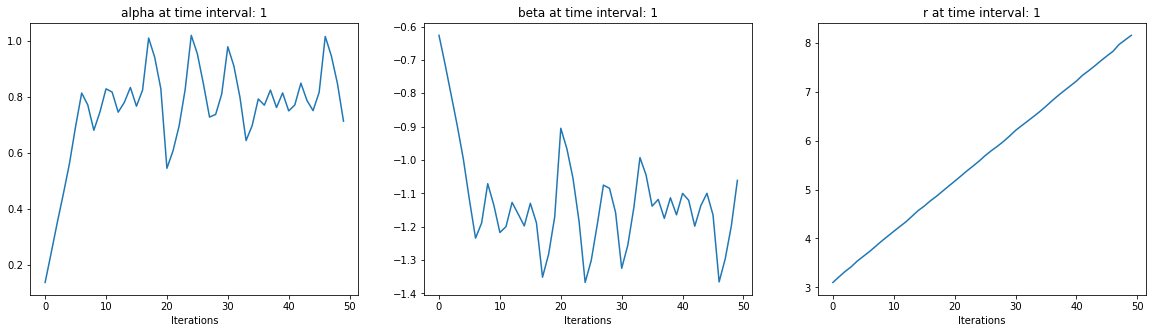

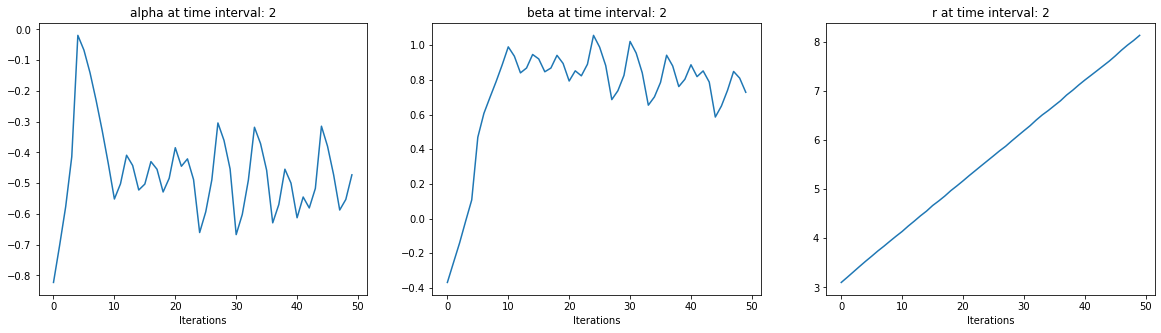

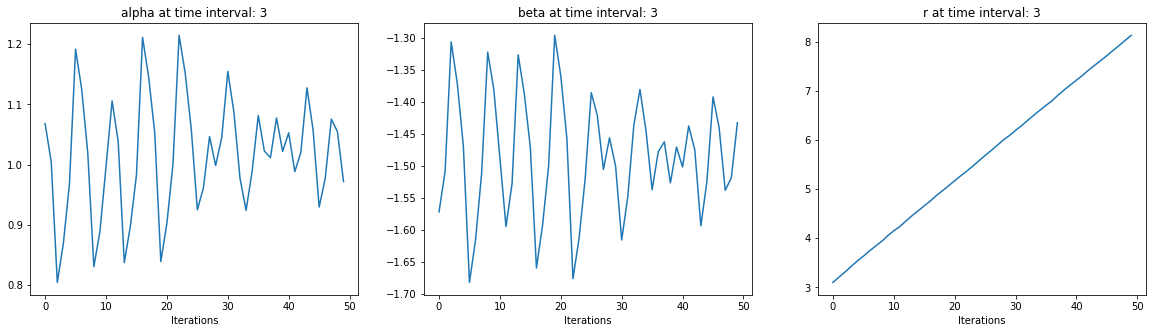

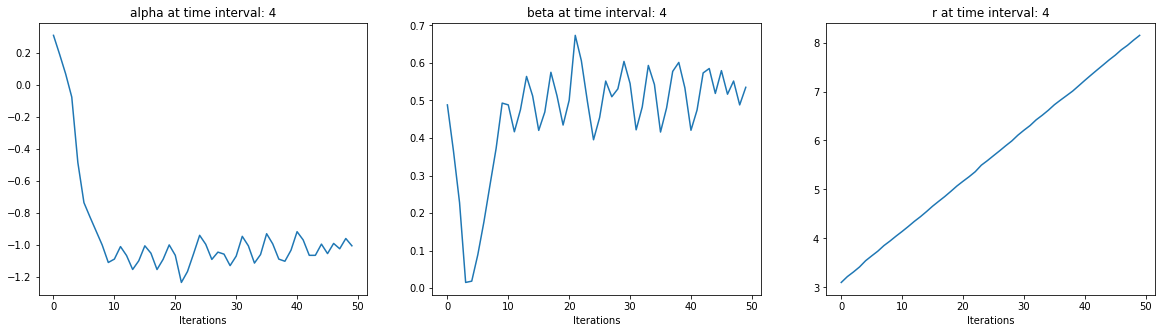

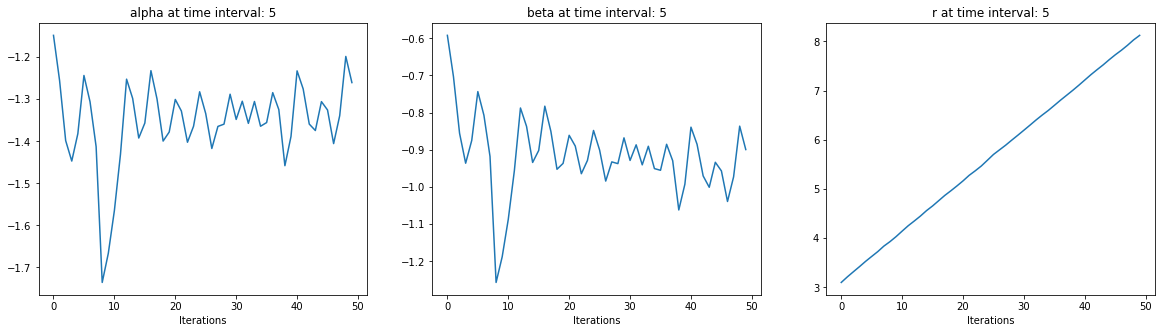

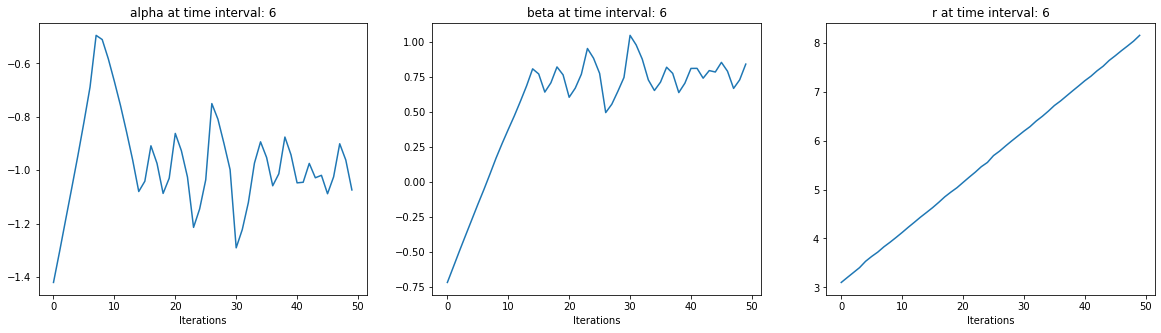

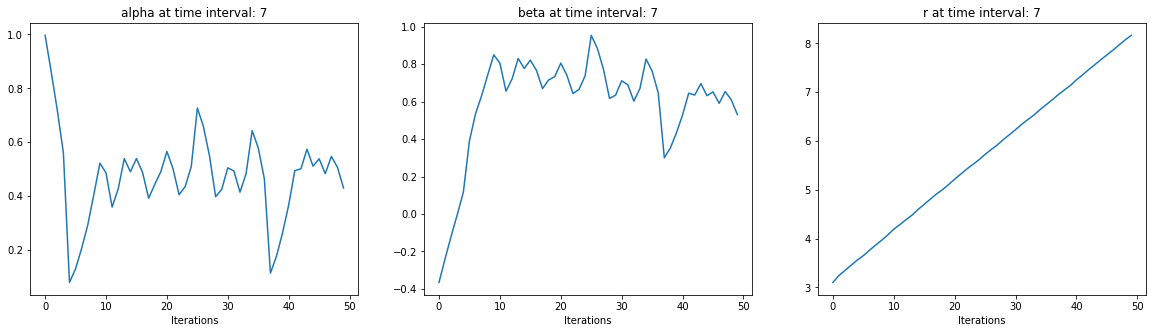

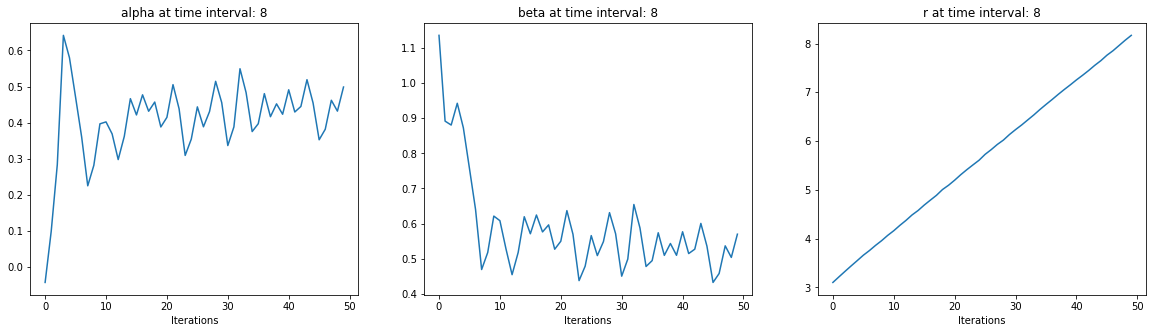

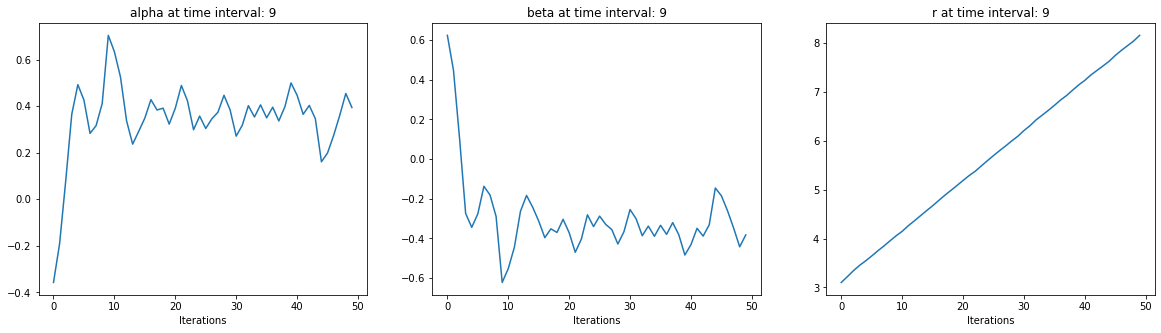

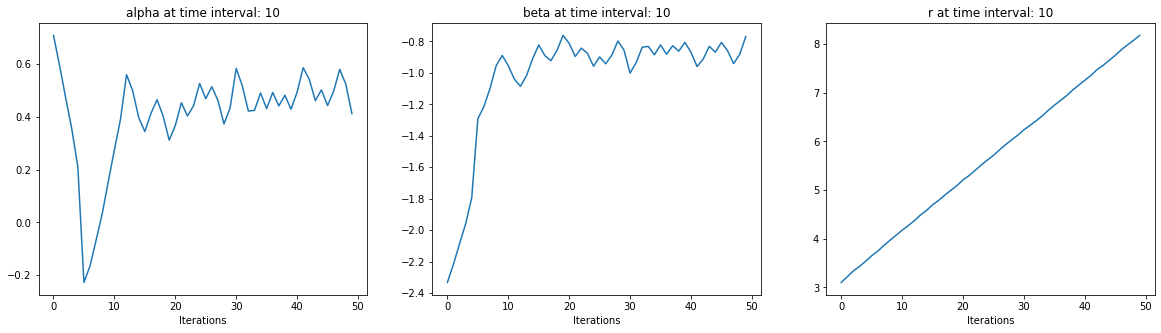

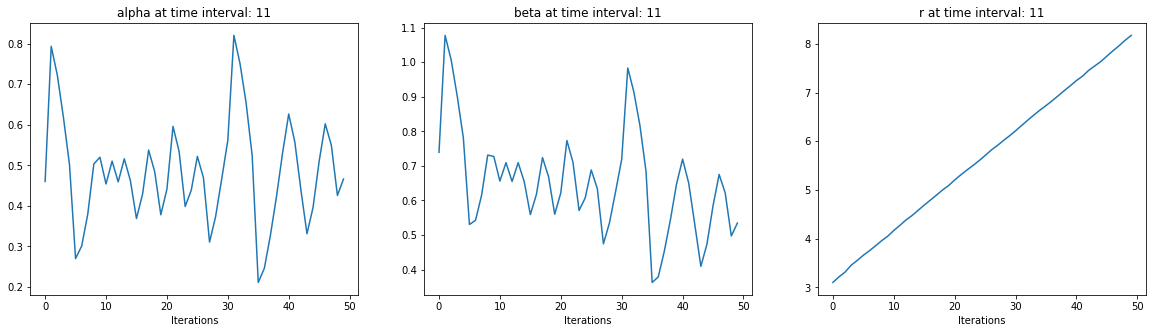

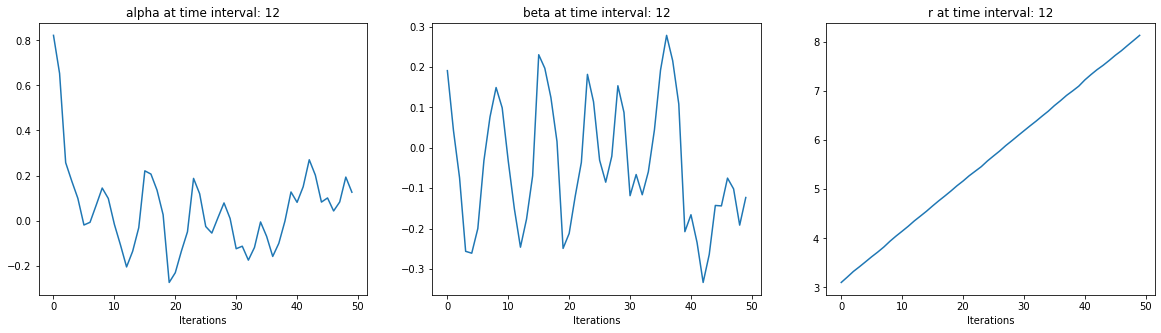

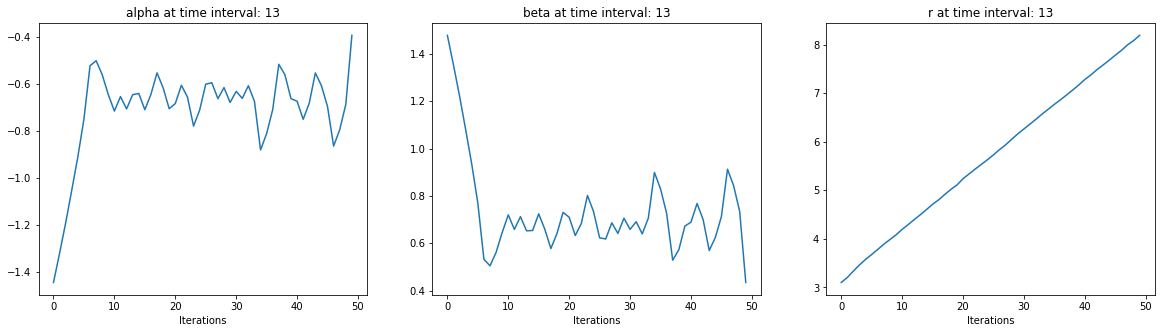

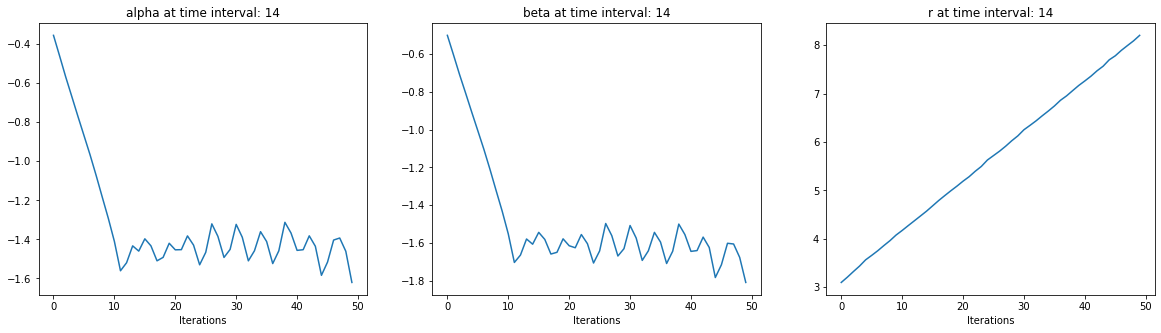

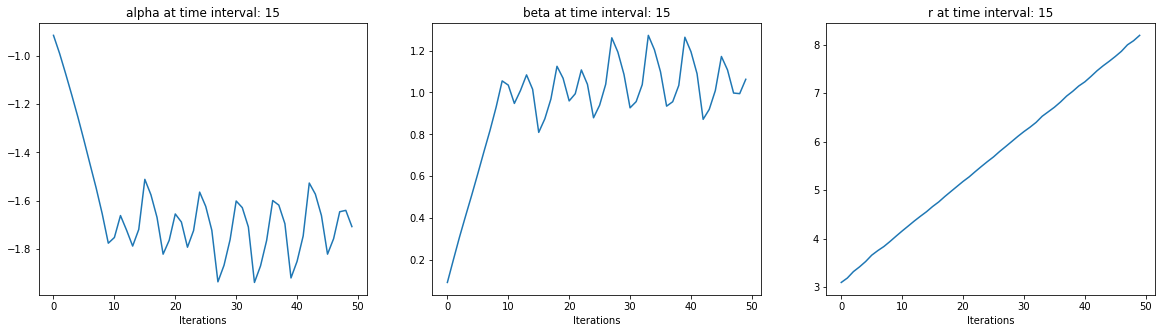

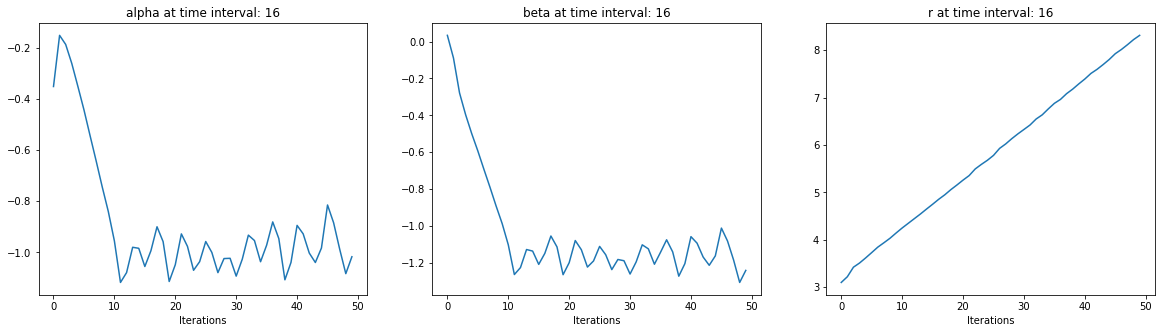

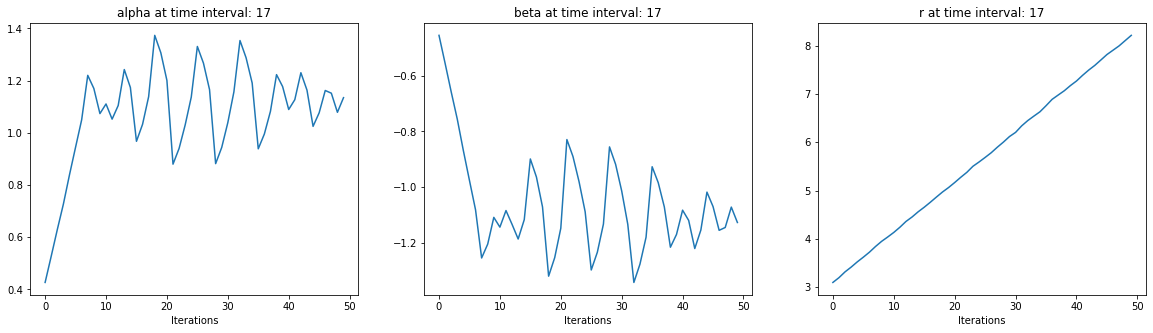

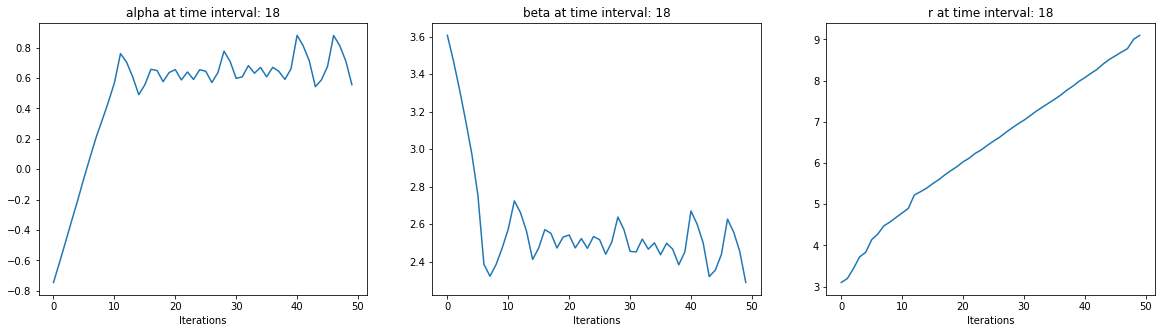

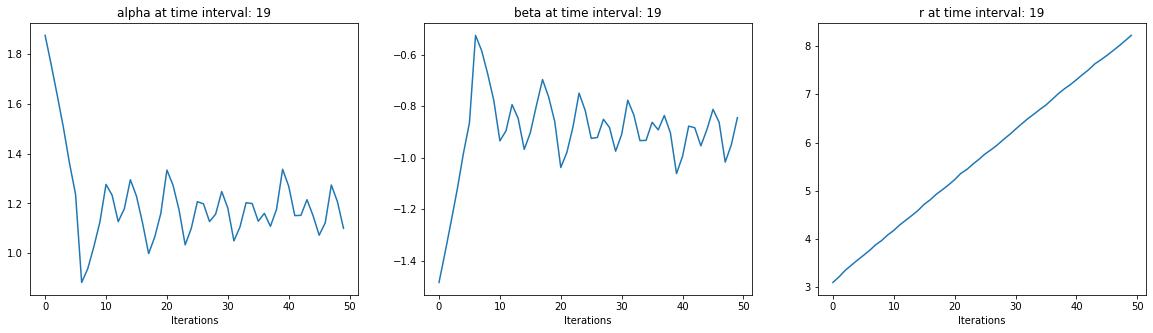

In [22]:
it_names = ['50']
par_names = ['alpha', 'beta', 'r']
for item, name in zip(output, it_names):
    vp__pts, vp__mean, vp__std, vp__pars = item[0], item[1], item[2], item[3]
    P, T, IT = len(par_names), obs_time.shape[0], 30

    for t in range(T-1):
        fig, ax = plt.subplots(nrows=1, ncols=P, figsize=(20, 5))
        for j, ax in enumerate(ax.ravel()):
            ax.plot(vp__pars[par_names[j]][t, :])
            ax.set_title(par_names[j] + " at time interval: %d" % t)
            ax.set_xlabel("Iterations")
        title = "Adam_" + "time_" + str(t) + "_iteration_" + name
#         plt.savefig("figures/" + title)
        plt.show()

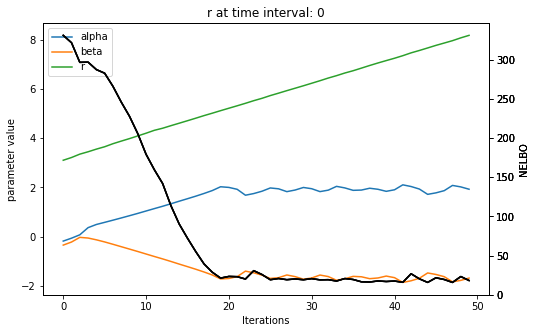

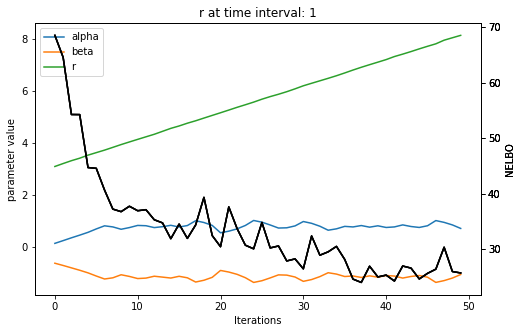

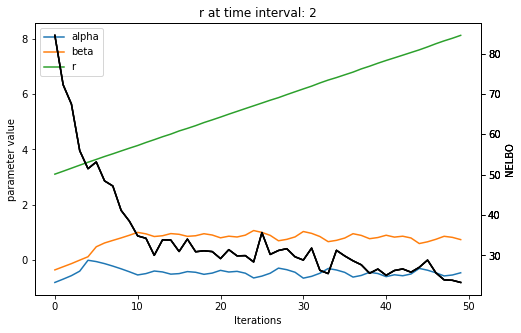

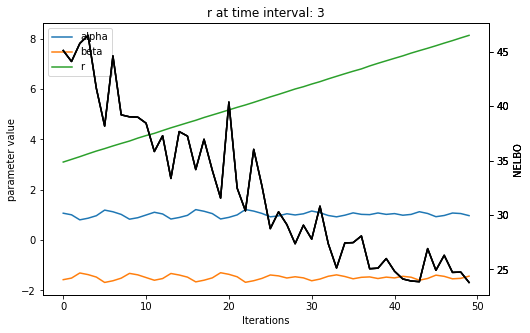

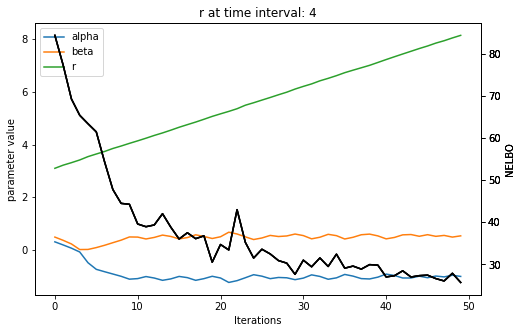

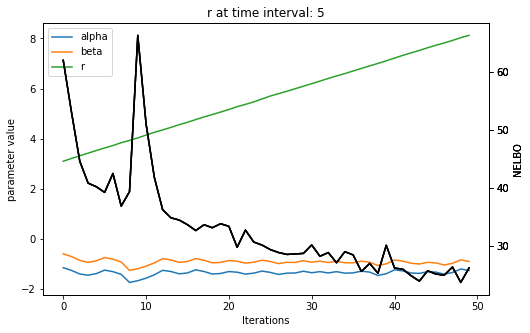

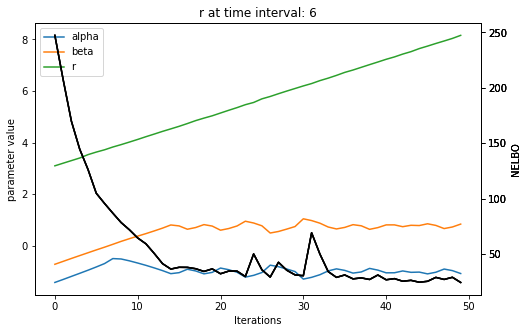

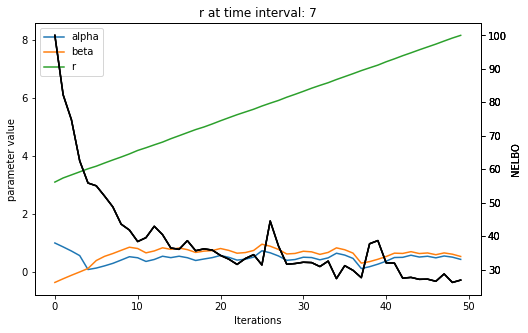

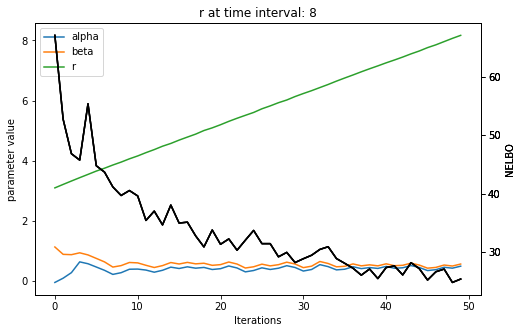

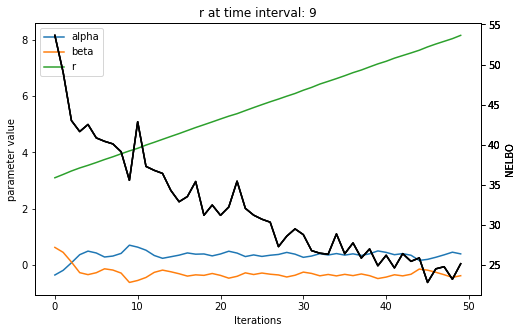

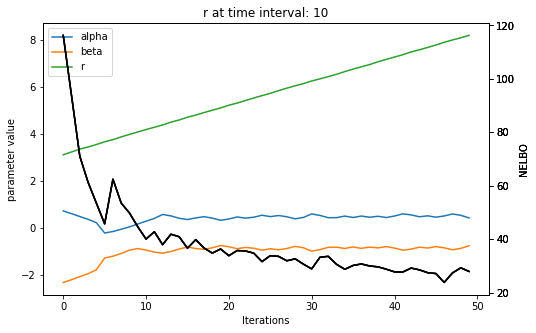

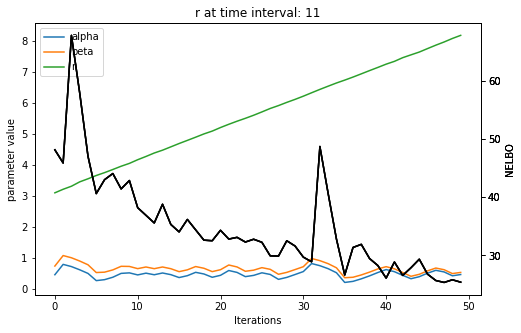

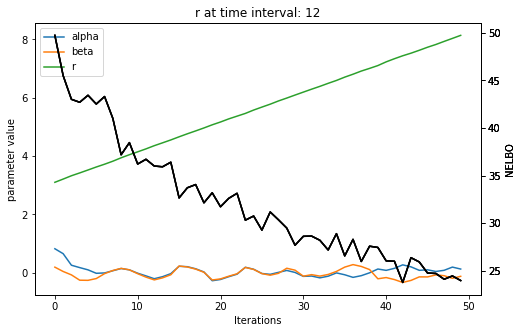

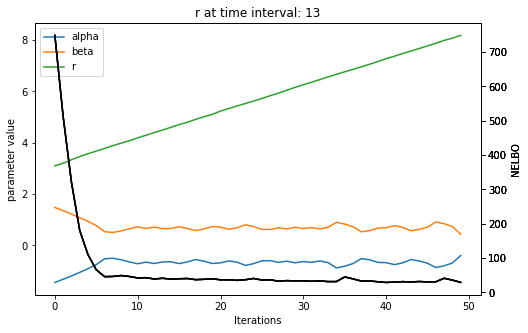

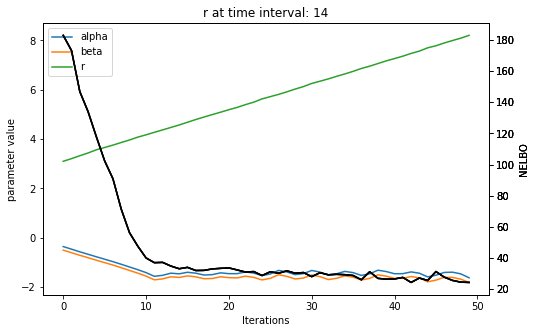

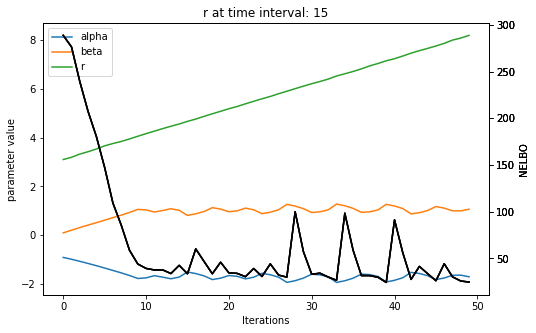

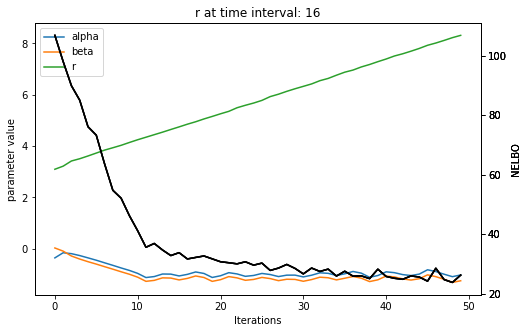

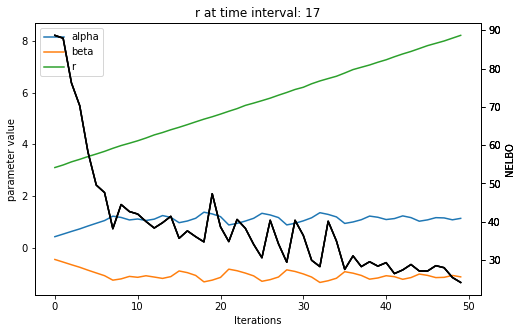

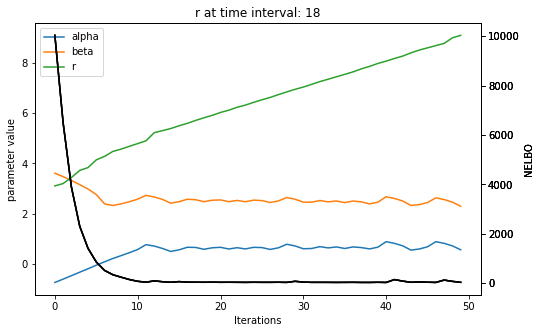

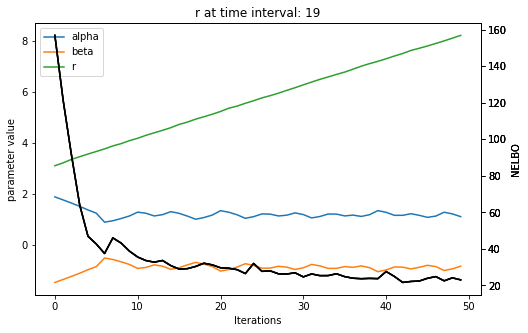

In [23]:
it_names = ['50']
par_names = ['alpha', 'beta', 'r']
for item, name in zip(output, it_names):
    vp__pts, vp__mean, vp__std, vp__pars = item[0], item[1], item[2], item[3]
    P, T, IT = len(par_names), obs_time.shape[0], 30

    for t in range(T-1):
        fig, ax1 = plt.subplots(figsize=(8, 5))
        for j in range(len(par_names)):
            ax1.plot(vp__pars[par_names[j]][t, :], label=par_names[j])
            ax1.set_title(par_names[j] + " at time interval: %d" % t)
            ax1.set_xlabel("Iterations")
            ax1.set_ylabel("parameter value")
            ax1.legend()
            ax2 = ax1.twinx()
            ax2.plot(vp__obj['NELBO'][t], label='Negative ELBO', color='black')
            ax2.set_ylabel("NELBO", color='black')
#             ax2.axhline(-20, linestyle='dashed', color='grey')
            
        title = "Adam_" + "time_" + str(t) + "_iteration_" + name
#         plt.savefig("figures/" + title)
        plt.show()

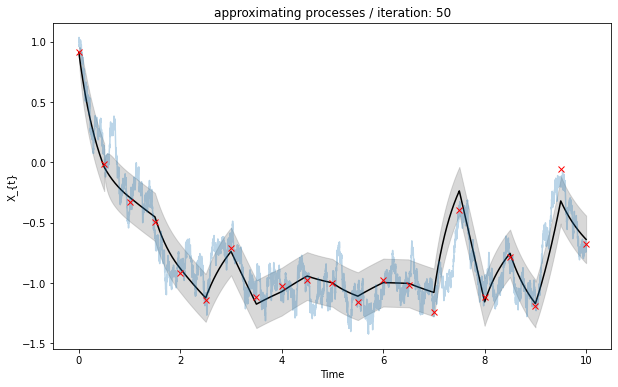

In [27]:
it_names = ['50']
for item, name in zip(output, it_names):
    vp__pts, vp__mean, vp__std, vp__pars = item[0], item[1], item[2], item[3]
    
    plt.figure(figsize=(10,6))
    plt.plot(vp__pts.T, vp__mean.T, color='black')
    plt.fill_between(vp__pts, vp__mean + vp__std, vp__mean - vp__std, alpha=0.3, color='grey')
    plt.plot(true_sde_pts, true_sde_trj, alpha=0.3)
    plt.plot(obs_time, obs, 'rx')
    plt.xlabel("Time")
    plt.ylabel(r"X_{t}")
    title = "approximating processes / iteration: " + name
    plt.title(title)
    file_name = "Adam_" + "approx_process_" + "iteration_" + name
#     plt.savefig("figures/" + file_name)
    plt.show()

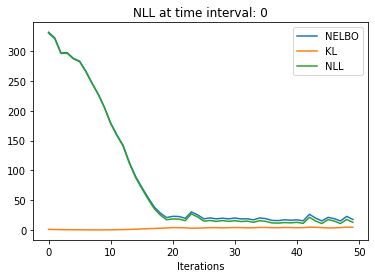

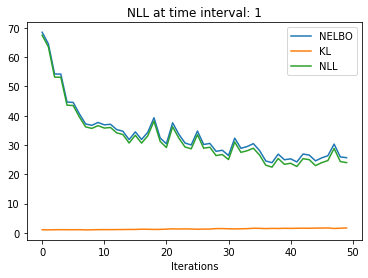

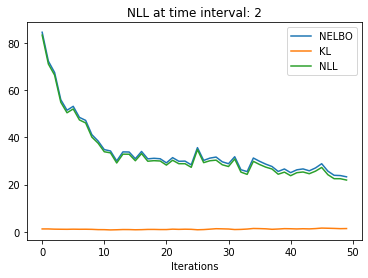

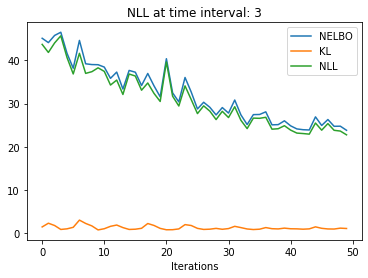

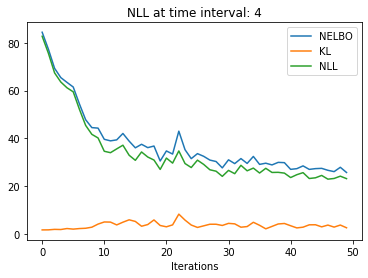

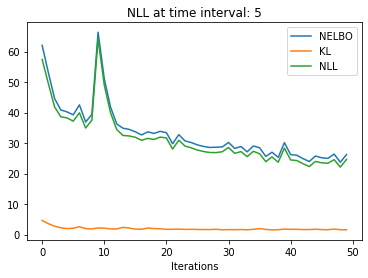

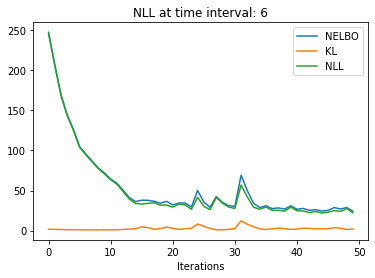

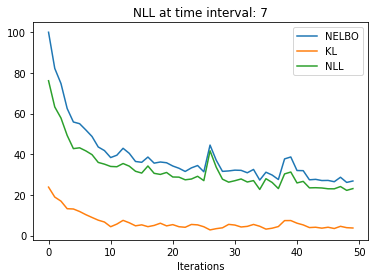

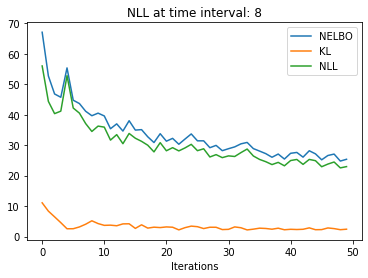

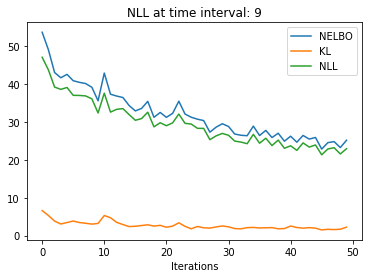

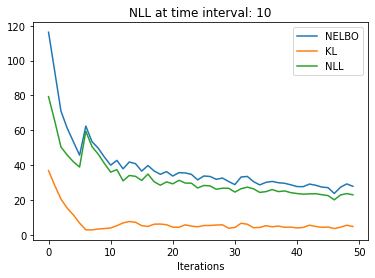

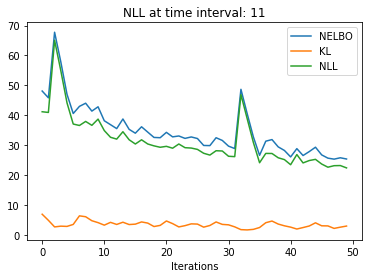

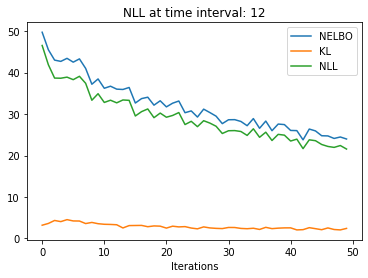

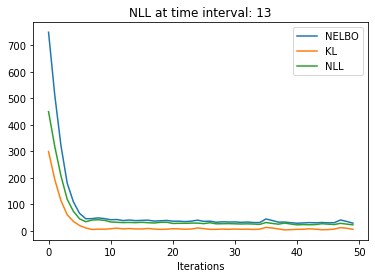

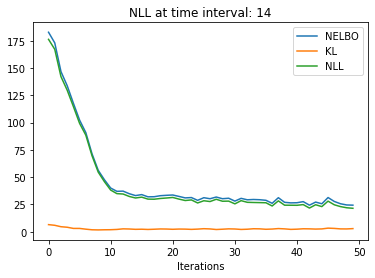

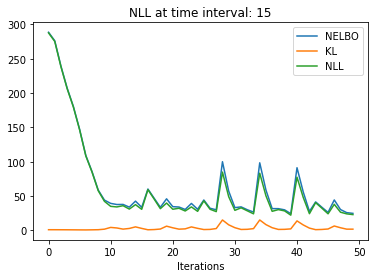

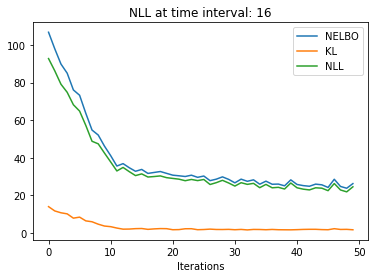

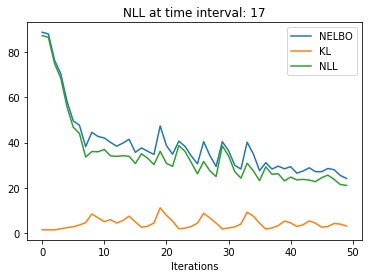

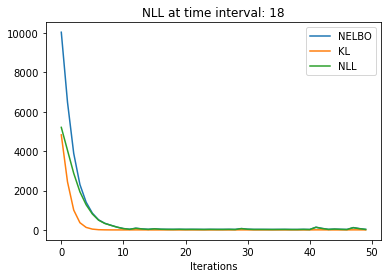

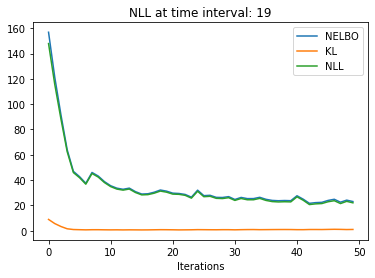

In [25]:
it_names = ['50']
obj_names = ['NELBO', 'KL', 'NLL']
for item, name in zip(output, it_names):
    P, T, IT = len(par_names), obs_time.shape[0], 30

    for t in range(T-1):
        plt.plot(figsize=(8, 6))
        for j in range(len(obj_names)):
            plt.plot(vp__obj[obj_names[j]][t], label=obj_names[j])
            plt.title(obj_names[j] + " at time interval: %d" % t)
            plt.xlabel("Iterations")
#             ax1.set_ylabel(obj_names[j])
            plt.legend()
            
        title = "Adam_" + "time_" + str(t) + "_iteration_" + name
#         plt.savefig("figures/" + title)
        plt.show()

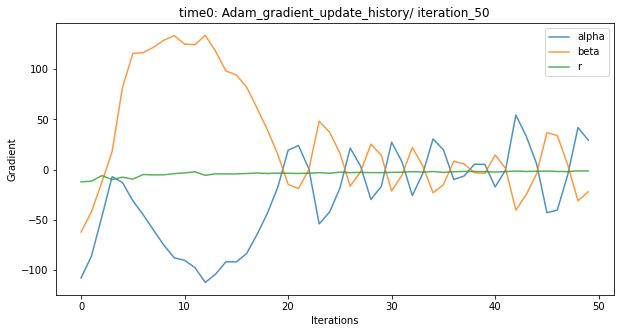

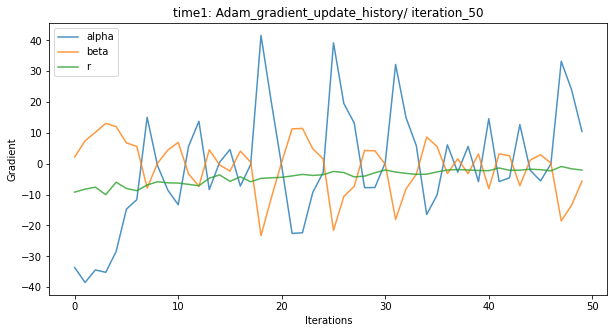

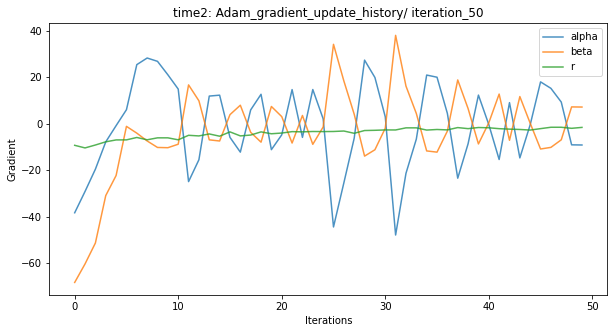

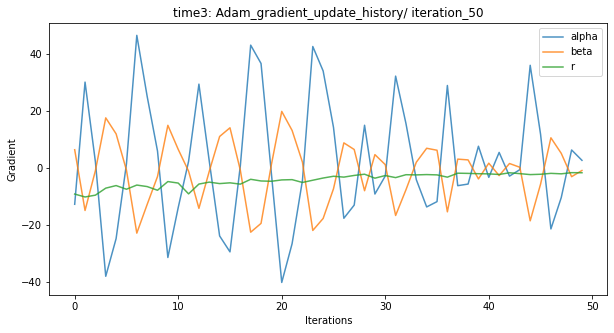

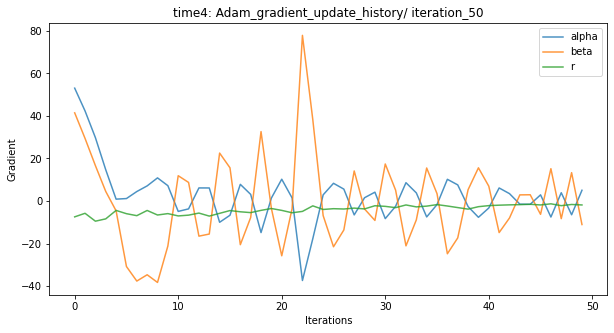

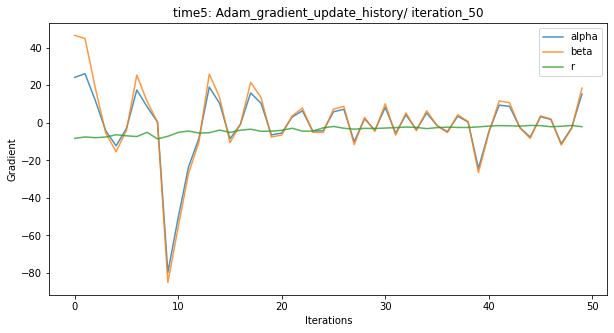

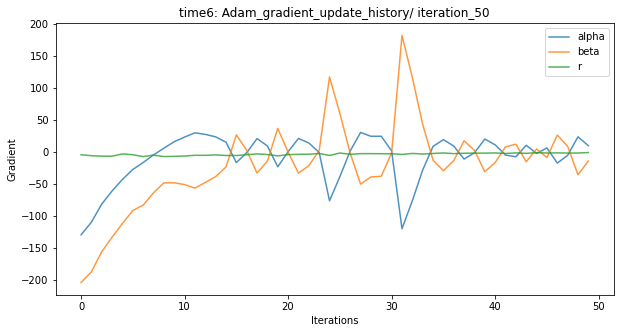

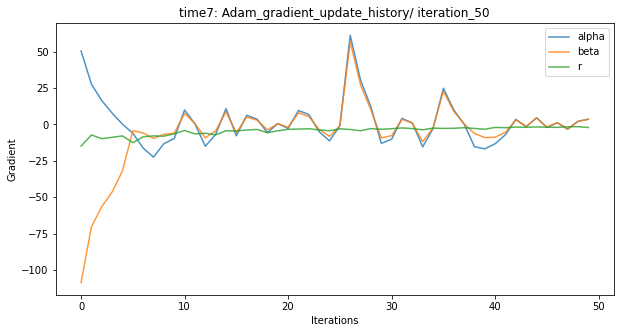

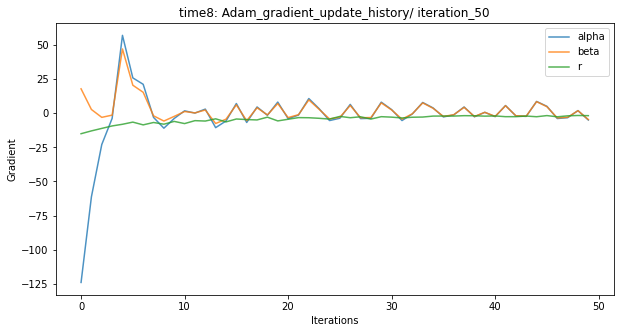

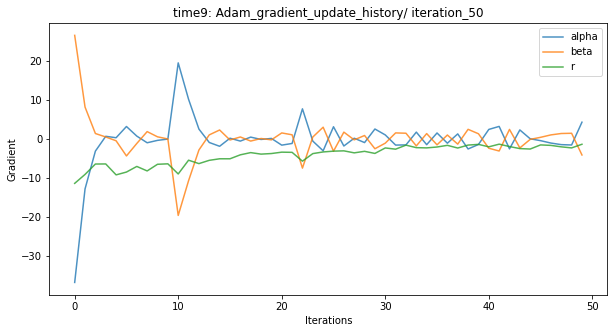

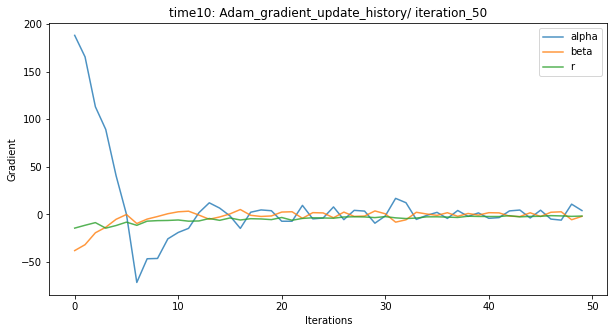

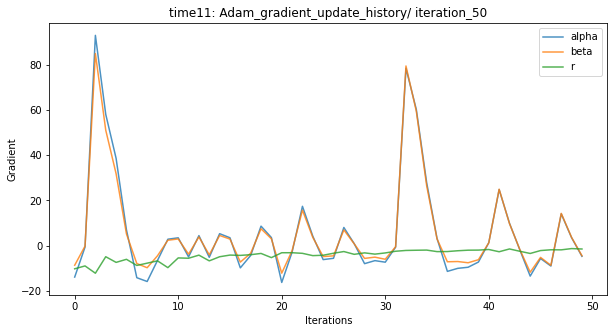

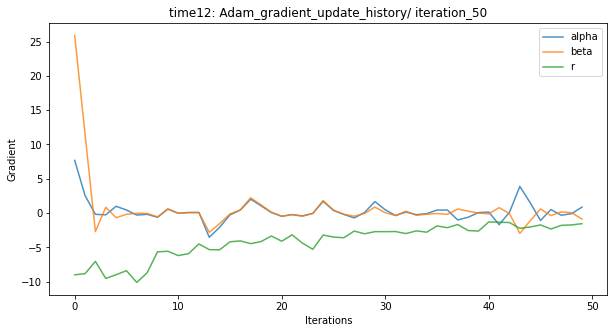

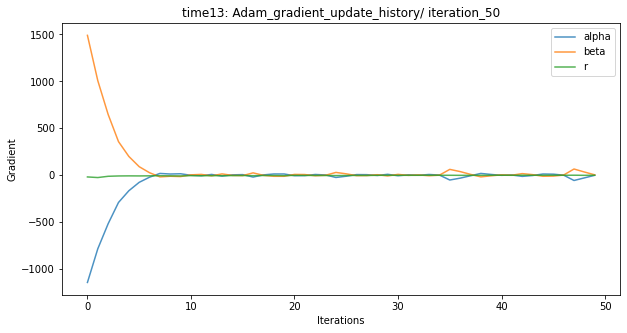

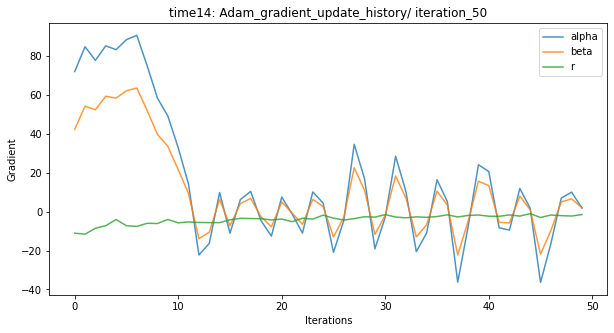

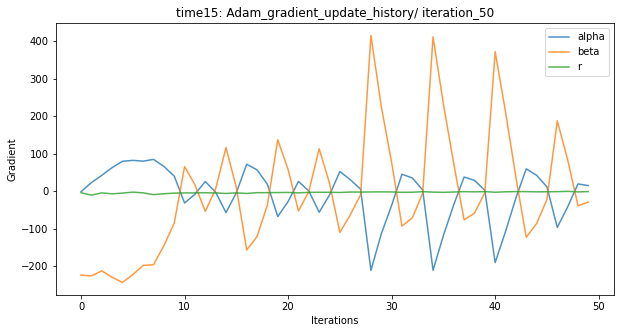

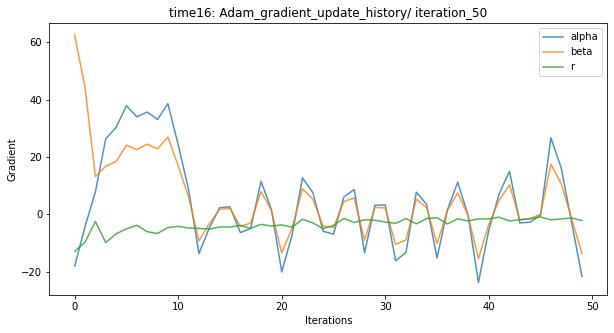

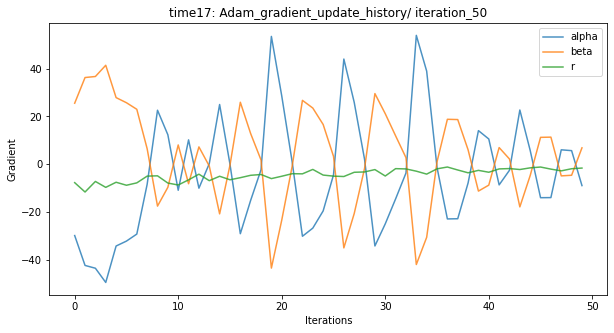

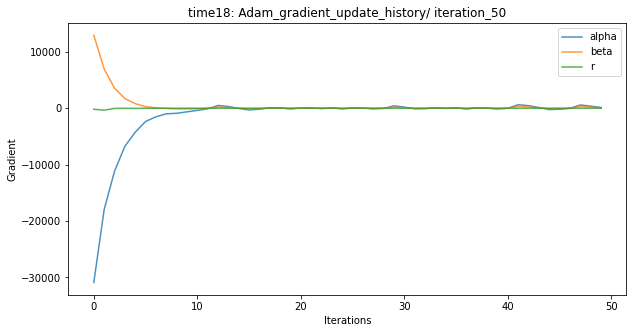

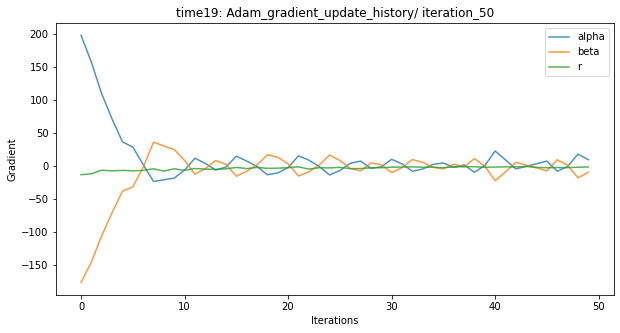

In [26]:
it_names = ['50']
for item, name in zip(output, it_names):
    vp_grads = item[4]
    for t in range(T-1):
        plt.figure(figsize=(10,5))

        for key in vp_grads.keys():
            plt.plot(vp_grads[key][t], label=key, alpha=0.8)
            plt.ylabel("Gradient")
            plt.xlabel("Iterations")
#             plt.axhline(np.mean(vp_grads[key][t]), linestyle='dashed', label=str(np.mean(vp_grads[key]).round(2)))
            plt.legend()

        file_name = "time" + str(t) + ": Adam_" + "gradient_update_history/ " + "iteration_" + name
        plt.title(file_name)
#     plt.savefig("figures/" + file_name)
    plt.show()

In [31]:
with open('EX04_DW_BVI', 'wb') as f:
    pickle.dump(output[0], f)

Fix $\alpha$ and optimize the other paramters, $\beta, r$

In [ ]:
fix_pars = {'alpha': torch.tensor(1.)}

In [ ]:
output = []
for it in tq.tqdm([50]):
    vp__pts, vp__mean, vp__std, vp__pars, vp__grads, vp__obj = Optimize(torch.tensor([sde_sigma]),\
                                                      obs, obs_time, obs_sigma, \
                                                      init_state="Random", M=1500, \
                                                      FIX_PAR = fix_pars,
                                                               \
                                                      IT=it, vN=150, learning_rate=0.05, \
                                                      Optimizer="Adam", beta_1 = 0.3, beta_2 = 0.01)
    output.append([vp__pts, vp__mean, vp__std, vp__pars, vp__grads])

In [ ]:
it_names = ['50']
par_names = ['alpha', 'beta', 'r']
for item, name in zip(output, it_names):
    vp__pts, vp__mean, vp__std, vp__pars = item[0], item[1], item[2], item[3]
    P, T, IT = len(par_names), obs_time.shape[0], 30

    for t in range(T-1):
        fig, ax1 = plt.subplots(figsize=(8, 5))
        for j in range(len(par_names)):
            ax1.plot(vp__pars[par_names[j]][t, :], label=par_names[j])
            ax1.set_title(par_names[j] + " at time interval: %d" % t)
            ax1.set_xlabel("Iterations")
            ax1.set_ylabel("parameter value")
            ax1.legend()
            ax2 = ax1.twinx()
            ax2.plot(vp__obj['NELBO'][t], label='Negative ELBO', color='black')
            ax2.set_ylabel("NELBO", color='black')
#             ax2.axhline(-20, linestyle='dashed', color='grey')
            
        title = "Adam_" + "time_" + str(t) + "_iteration_" + name
#         plt.savefig("figures/" + title)
        plt.show()

In [ ]:
it_names = ['50']
for item, name in zip(output, it_names):
    vp__pts, vp__mean, vp__std, vp__pars = item[0], item[1], item[2], item[3]
    
    plt.figure(figsize=(10,6))
    plt.plot(vp__pts.T, vp__mean.T, color='black')
    plt.fill_between(vp__pts, vp__mean + vp__std, vp__mean - vp__std, alpha=0.3, color='grey')
    plt.plot(true_sde_pts, true_sde_trj, alpha=0.2)
    plt.plot(obs_time, obs, 'rx')
    plt.xlabel("Time")
    plt.ylabel(r"X_{t}")
    title = "approximating processes / iteration: " + name
    plt.title(title)
    file_name = "Adam_" + "approx_process_" + "iteration_" + name
#     plt.savefig("figures/" + file_name)
    plt.show()

FIX $\beta$

In [ ]:
fix_pars = {'beta': torch.tensor(1.)}

In [ ]:
output = []
for it in tq.tqdm([50]):
    vp__pts, vp__mean, vp__std, vp__pars, vp__grads, vp__obj = Optimize(torch.tensor([sde_sigma]),\
                                                      obs, obs_time, obs_sigma, \
                                                      init_state="Random", M=1500, \
                                                      FIX_PAR = fix_pars, K=500,
                                                               \
                                                      IT=it, vN=150, learning_rate=0.05, \
                                                      Optimizer="Adam", beta_1 = 0.3, beta_2 = 0.01)
    output.append([vp__pts, vp__mean, vp__std, vp__pars, vp__grads])

In [ ]:
it_names = ['50']
par_names = ['alpha', 'beta', 'r']
for item, name in zip(output, it_names):
    vp__pts, vp__mean, vp__std, vp__pars = item[0], item[1], item[2], item[3]
    P, T, IT = len(par_names), obs_time.shape[0], 30

    for t in range(T-1):
        fig, ax1 = plt.subplots(figsize=(8, 5))
        for j in range(len(par_names)):
            ax1.plot(vp__pars[par_names[j]][t, :], label=par_names[j])
            ax1.set_title(par_names[j] + " at time interval: %d" % t)
            ax1.set_xlabel("Iterations")
            ax1.set_ylabel("parameter value")
            ax1.legend()
            ax2 = ax1.twinx()
            ax2.plot(vp__obj['NELBO'][t], label='Negative ELBO', color='black')
            ax2.set_ylabel("NELBO", color='black')
#             ax2.axhline(-20, linestyle='dashed', color='grey')
            
        title = "Adam_" + "time_" + str(t) + "_iteration_" + name
#         plt.savefig("figures/" + title)
        plt.show()

In [ ]:
it_names = ['50']
for item, name in zip(output, it_names):
    vp__pts, vp__mean, vp__std, vp__pars = item[0], item[1], item[2], item[3]
    
    plt.figure(figsize=(10,6))
    plt.plot(vp__pts.T, vp__mean.T, color='black')
    plt.fill_between(vp__pts, vp__mean + vp__std, vp__mean - vp__std, alpha=0.3, color='grey')
    plt.plot(true_sde_pts, true_sde_trj, alpha=0.2)
    plt.plot(obs_time, obs, 'rx')
    plt.xlabel("Time")
    plt.ylabel(r"X_{t}")
    title = "approximating processes / iteration: " + name
    plt.title(title)
    file_name = "Adam_" + "approx_process_" + "iteration_" + name
#     plt.savefig("figures/" + file_name)
    plt.show()

In [ ]:
it_names = ['50']
obj_names = ['NELBO', 'KL', 'NLL']
for item, name in zip(output, it_names):
    P, T, IT = len(par_names), obs_time.shape[0], 30

    for t in range(T-1):
        plt.plot(figsize=(8, 6))
        for j in range(len(obj_names)):
            plt.plot(vp__obj[obj_names[j]][t], label=obj_names[j])
            plt.title(obj_names[j] + " at time interval: %d" % t)
            plt.xlabel("Iterations")
#             ax1.set_ylabel(obj_names[j])
            plt.legend()
            
        title = "Adam_" + "time_" + str(t) + "_iteration_" + name
#         plt.savefig("figures/" + title)
        plt.show()

FIX $\alpha, \beta$

In [ ]:
fix_pars = {'beta': torch.tensor(1.), 'alpha':torch.tensor(2.)}

In [ ]:
output = []
for it in tq.tqdm([50]):
    vp__pts, vp__mean, vp__std, vp__pars, vp__grads, vp__obj = Optimize(torch.tensor([sde_sigma]),\
                                                      obs, obs_time, obs_sigma, \
                                                      init_state="Random", M=1500, \
                                                      FIX_PAR = fix_pars,
                                                               \
                                                      IT=it, vN=150, learning_rate=0.05, \
                                                      Optimizer="Adam", beta_1 = 0.1, beta_2 = 0.01)
    output.append([vp__pts, vp__mean, vp__std, vp__pars, vp__grads])

In [ ]:
it_names = ['50']
par_names = ['alpha', 'beta', 'r']
for item, name in zip(output, it_names):
    vp__pts, vp__mean, vp__std, vp__pars = item[0], item[1], item[2], item[3]
    P, T, IT = len(par_names), obs_time.shape[0], 30

    for t in range(T-1):
        fig, ax1 = plt.subplots(figsize=(8, 5))
        for j in range(len(par_names)):
            ax1.plot(vp__pars[par_names[j]][t, :], label=par_names[j])
            ax1.set_title(par_names[j] + " at time interval: %d" % t)
            ax1.set_xlabel("Iterations")
            ax1.set_ylabel("parameter value")
            ax1.legend()
            ax2 = ax1.twinx()
            ax2.plot(vp__obj['NELBO'][t], label='Negative ELBO', color='black')
            ax2.set_ylabel("NELBO", color='black')
#             ax2.axhline(-20, linestyle='dashed', color='grey')
            
        title = "Adam_" + "time_" + str(t) + "_iteration_" + name
#         plt.savefig("figures/" + title)
        plt.show()

In [ ]:
it_names = ['50']
for item, name in zip(output, it_names):
    vp__pts, vp__mean, vp__std, vp__pars = item[0], item[1], item[2], item[3]
    
    plt.figure(figsize=(10,6))
    plt.plot(vp__pts.T, vp__mean.T, color='black')
    plt.fill_between(vp__pts, vp__mean + vp__std, vp__mean - vp__std, alpha=0.3, color='grey')
    plt.plot(true_sde_pts, true_sde_trj, alpha=0.2)
    plt.plot(obs_time, obs, 'rx')
    plt.xlabel("Time")
    plt.ylabel(r"X_{t}")
    title = "approximating processes / iteration: " + name
    plt.title(title)
    file_name = "Adam_" + "approx_process_" + "iteration_" + name
#     plt.savefig("figures/" + file_name)
    plt.show()

what if we reduce the time step by factor of 50?

In [ ]:
output = []
for it in tq.tqdm([50]):
    vp__pts, vp__mean, vp__std, vp__pars, vp__grads, vp__obj = Optimize(torch.tensor([sde_sigma]),\
                                                      obs, obs_time/50, obs_sigma, \
                                                      init_state="Random", M=1500, \
#                                                       FIX_PAR = fix_pars,
#                                                                \
                                                      IT=it, vN=150, learning_rate=0.15, \
                                                      Optimizer="Adam", beta_1 = 0.5, beta_2 = 0.01)
    output.append([vp__pts, vp__mean, vp__std, vp__pars, vp__grads])

In [ ]:
it_names = ['50']
par_names = ['alpha', 'beta', 'r']
for item, name in zip(output, it_names):
    vp__pts, vp__mean, vp__std, vp__pars = item[0], item[1], item[2], item[3]
    P, T, IT = len(par_names), obs_time.shape[0], 30

    for t in range(T-1):
        fig, ax1 = plt.subplots(figsize=(8, 5))
        for j in range(len(par_names)):
            ax1.plot(vp__pars[par_names[j]][t, :], label=par_names[j])
            ax1.set_title(par_names[j] + " at time interval: %d" % t)
            ax1.set_xlabel("Iterations")
            ax1.set_ylabel("parameter value")
            ax1.legend()
            ax2 = ax1.twinx()
            ax2.plot(-1 * vp__obj['NELBO'][t], label='Negative ELBO', color='black')
            ax2.set_ylabel("NELBO", color='black')
#             ax2.axhline(-20, linestyle='dashed', color='grey')
            
        title = "Adam_" + "time_" + str(t) + "_iteration_" + name
#         plt.savefig("figures/" + title)
        plt.show()

In [ ]:
it_names = ['50']
for item, name in zip(output, it_names):
    vp__pts, vp__mean, vp__std, vp__pars = item[0], item[1], item[2], item[3]
    
    plt.figure(figsize=(10,6))
    plt.plot(vp__pts.T, vp__mean.T, color='black')
    plt.fill_between(vp__pts, vp__mean + vp__std, vp__mean - vp__std, alpha=0.3, color='grey')
    plt.plot(true_sde_pts/50, true_sde_trj, alpha=0.2)
    plt.plot(obs_time/50, obs, 'rx')
    title = "approximating processes / iteration: " + name
    plt.title(title)
    file_name = "Adam_" + "approx_process_" + "iteration_" + name
#     plt.savefig("figures/" + file_name)
    plt.show()

In [ ]:
it_names = ['50']
obj_names = ['NELBO', 'KL', 'NLL']
for item, name in zip(output, it_names):
    P, T, IT = len(par_names), obs_time.shape[0], 30

    for t in range(T-1):
        plt.plot(figsize=(8, 6))
        for j in range(len(obj_names)):
            plt.plot(vp__obj[obj_names[j]][t], label=obj_names[j])
            plt.title(obj_names[j] + " at time interval: %d" % t)
            plt.xlabel("Iterations")
#             ax1.set_ylabel(obj_names[j])
            plt.legend()
            
        title = "Adam_" + "time_" + str(t) + "_iteration_" + name
#         plt.savefig("figures/" + title)
        plt.show()